# Introduction - Video Game Sales Analysis

I am working with a dataset provided to me by Practicum for use in this project. The data deals with video game sales, and my goal is to uncover patterns that can determine whether or not a game succeeds for the year following the end of the dataset.

Our first step will be to preprocess the data - deal with column names, datatypes, duplicates, and missing values, and add a total sales column for each row.

Then we will check out the numbers through the years and decide whether we want to use all of the data, or just data from recent years. We also want to figure out the typical lifespan of a console, and which consoles have been performing exceptionally well or poorly recently. We can compare total/average global sales across platforms to help with this. We will look at the correlation between reviews and sales for the Xbox One platform, and then compare the top games for this console to the sales on other consoles. We will then try to determine any patterns behind the most and least profitable genres.

After that we will look at each region and identify the top platforms and genres for each one, and determine whether or not the games' ESRB ratings affect sales.

Finally I will use statistical tests to:

    - Compare average user ratings of the Xbox One and PC platforms (levene test, normal test, t-test with independent samples)
    - Compare average user ratings for the Action and Sports genres (levene test, normal test, t-test with independent samples)
    - Compare average user ratings for each ESRB rating (levene test, normal test, one-way ANOVA test, tukey test)    

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import statistical testing functions
from scipy.stats import levene
from scipy.stats import normaltest
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd as tukey

In [2]:
df = pd.read_csv('moved_games.csv')

# Preprocessing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Name, platform, genre, and all sales columns appear to be essentially complete. Many of the number columns are already in the correct datatype. I will need to look into user score and fix whatever is preventing it from being a float type.

First let's fix the column names.

In [4]:
df.columns = df.columns.str.lower()

In [5]:
df.head() # Check out data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [6]:
df.duplicated().sum() # Check for fully duplicate rows

0

In [7]:
desc = df.describe(include='all') # Let's check out an overview of the summary statistics to see if values make sense
display(desc)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
count,16713,16715,16446.000000,16713,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000,10014,9949
unique,11559,31,NaN,12,NaN,NaN,NaN,NaN,NaN,96,8
top,Need for Speed: Most Wanted,PS2,NaN,Action,NaN,NaN,NaN,NaN,NaN,tbd,E
freq,12,2161,NaN,3369,NaN,NaN,NaN,NaN,NaN,2424,3990
mean,NaN,NaN,2006.484616,NaN,0.263377,0.145060,0.077617,0.047342,68.967679,NaN,NaN
std,NaN,NaN,5.877050,NaN,0.813604,0.503339,0.308853,0.186731,13.938165,NaN,NaN
min,NaN,NaN,1980.000000,NaN,0.000000,0.000000,0.000000,0.000000,13.000000,NaN,NaN
25%,NaN,NaN,2003.000000,NaN,0.000000,0.000000,0.000000,0.000000,60.000000,NaN,NaN
50%,NaN,NaN,2007.000000,NaN,0.080000,0.020000,0.000000,0.010000,71.000000,NaN,NaN
75%,NaN,NaN,2010.000000,NaN,0.240000,0.110000,0.040000,0.030000,79.000000,NaN,NaN


Platform seems good. Year_of_release tells us that the data ranges from 1980 to 2016. Genre, sales columns, rating, and critic_score all look reasonable. 

Name seems to have some duplicates, let's look into that soon.

User_score has a high number of "tbd" scores, which may correlate with recently released games whose scores have not been reported yet - I will check this. I do want this column to be numeric type so that I can perform calculations, so I will just turn these "tbd" values into nans. As the data is updated, it can be fed into this notebook and all calculations can be rerun to improve precision.

## User scores

In [8]:
# Look at years where at least one user score is tbd
df_tbd = df[df.user_score == 'tbd']
print(sorted(df_tbd.year_of_release.unique()))

# Hmm, there is a wide spread of years. How many are from 2016?
tbd_2016 = df_tbd.query('year_of_release == 2016').count()['year_of_release']
print(tbd_2016)

[1997.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, nan, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0]
34


Text(0.5, 1.0, 'How many games each year had a tbd user score?')

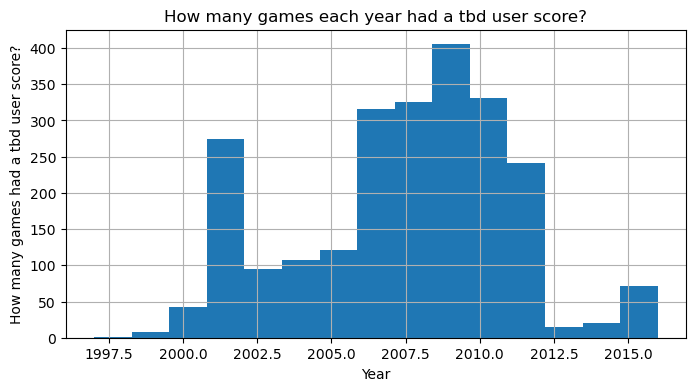

In [9]:
df_tbd.year_of_release.hist(bins=15, figsize=[8,4])
plt.xlabel("Year")
plt.ylabel("How many games had a tbd user score?")
plt.title("How many games each year had a tbd user score?")

In [10]:
ratio_2016_tbd = tbd_2016 / desc.loc['freq', 'user_score']
ratio_2016_tbd

0.014026402640264026

Only a very small percentage of tbd's come from 2016. It appears that the vast majority of the 'tbd' data may never arrive. Let's go ahead and turn them all into nans, and change datatypes to float.

In [11]:
df.user_score = df.user_score.apply(pd.to_numeric, errors='coerce')

In [12]:
df.info() # Verify success

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


User score has dropped the tbd values and became float datatype. I want to now look at year_of_release to determine why they are not integers.

## Year of Release

In [13]:
df.year_of_release.unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])

Let's replace nan's here with 0. A zero will clearly be separate from the rest of the years. The years can be changed to int, now that the nans are gone - the computer can use the ints more effectively and save on memory, while still knowing the inherent order of the years.

In [36]:
df.year_of_release = df.year_of_release.fillna(0)
df.year_of_release = df.year_of_release.astype('int')

In [37]:
df.info() # Verify success

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16714 entries, 0 to 16713
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16714 non-null  object  
 1   platform         16714 non-null  object  
 2   year_of_release  16714 non-null  int32   
 3   genre            16714 non-null  category
 4   na_sales         16714 non-null  float64 
 5   eu_sales         16714 non-null  float64 
 6   jp_sales         16714 non-null  float64 
 7   other_sales      16714 non-null  float64 
 8   critic_score     8136 non-null   float64 
 9   user_score       7589 non-null   float64 
 10  rating           16714 non-null  category
dtypes: category(2), float64(6), int32(1), object(2)
memory usage: 1.1+ MB


I want to look at the ratings column.

## Rating

In [16]:
df.rating.unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Some internet research reveals that 'K-A' is a precursor equivalent to 'E'. I will change these to 'E' for simplicity.

'RP' means the rating is pending. Let's look to see if this only applies to a small number of 2016 games.

In [17]:
df.rating = df.rating.replace('K-A', 'E') # Change 'K-A' to 'E'

df.query('rating=="RP"').count()['name']

3

Very few games have an 'RP' rating. Let's change nans into 'RP' rating for simplicity, as they each indicate a non-rating.

In [18]:
df.rating = df.rating.fillna('RP')

In [19]:
df.rating.unique() # Verify success
df.rating = df.rating.astype('category') # Change datatype to categorical

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16713 non-null  object  
 1   platform         16715 non-null  object  
 2   year_of_release  16715 non-null  category
 3   genre            16713 non-null  object  
 4   na_sales         16715 non-null  float64 
 5   eu_sales         16715 non-null  float64 
 6   jp_sales         16715 non-null  float64 
 7   other_sales      16715 non-null  float64 
 8   critic_score     8137 non-null   float64 
 9   user_score       7590 non-null   float64 
 10  rating           16715 non-null  category
dtypes: category(2), float64(6), object(3)
memory usage: 1.2+ MB


## Genre

In [21]:
df.genre.unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', nan], dtype=object)

In [22]:
genre_nan = df[df.genre.isna()]
genre_nan

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,RP
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,RP


There are only two nans. Let's just turn these into 'Misc'.

In [35]:
df.genre = df.genre.fillna('Misc')

# I will also change the datatype to save memory.
df.genre = df.genre.astype('category')

In [34]:
df.info() # Verify success

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16714 entries, 0 to 16713
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16714 non-null  object  
 1   platform         16714 non-null  object  
 2   year_of_release  16714 non-null  category
 3   genre            16714 non-null  category
 4   na_sales         16714 non-null  float64 
 5   eu_sales         16714 non-null  float64 
 6   jp_sales         16714 non-null  float64 
 7   other_sales      16714 non-null  float64 
 8   critic_score     8136 non-null   float64 
 9   user_score       7589 non-null   float64 
 10  rating           16714 non-null  category
dtypes: category(3), float64(6), object(2)
memory usage: 1.1+ MB


## Name

I mainly want to look for duplicates in this name column and see whether or not they should be removed.

In [25]:
df.duplicated(subset='name').sum()

5155

That's a lot of duplicate names. However, games tend to come out on a variety of platforms. Some games may share a name and platform but are totally distinct, coming out in a different year. Let's add these to the subsets.

In [26]:
dups = df[df.duplicated(subset=['name', 'platform', 'year_of_release'])]
madden = dups.loc[16230, 'name']

Two duplicates - let's first deal with the nan.

In [27]:
df[df.name.isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,Misc,1.78,0.53,0.00,0.08,NaN,NaN,RP
14244,NaN,GEN,1993.0,Misc,0.00,0.00,0.03,0.00,NaN,NaN,RP


These are two separate games. Let's replace the nan names with "Unknown".

In [28]:
df.name = df.name.fillna('Unknown')

Now let's deal with the Madden game.

In [29]:
df[df.name == madden]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
507,Madden NFL 13,X360,2012.0,Sports,2.53,0.15,0.0,0.17,81.0,5.8,E
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
3986,Madden NFL 13,Wii,2012.0,Sports,0.47,0.00,0.0,0.03,NaN,7.3,E
5887,Madden NFL 13,PSV,2012.0,Sports,0.28,0.00,0.0,0.02,63.0,7.3,E
7066,Madden NFL 13,WiiU,2012.0,Sports,0.21,0.00,0.0,0.02,75.0,6.7,E
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


So, rows 604 and 16230 are essentially duplicates. I'll add the sales from row 16230 to row 604, effectively combining them, before removing row 16230.

In [30]:
df.loc[604, 'eu_sales'] = df.loc[604, 'eu_sales'] + df.loc[16230, 'eu_sales']
df = df.drop(index=16230).reset_index(drop=True)

In [31]:
df[df.name == madden] # Verify success

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
507,Madden NFL 13,X360,2012.0,Sports,2.53,0.15,0.0,0.17,81.0,5.8,E
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.23,0.0,0.23,83.0,5.5,E
3986,Madden NFL 13,Wii,2012.0,Sports,0.47,0.00,0.0,0.03,NaN,7.3,E
5887,Madden NFL 13,PSV,2012.0,Sports,0.28,0.00,0.0,0.02,63.0,7.3,E
7066,Madden NFL 13,WiiU,2012.0,Sports,0.21,0.00,0.0,0.02,75.0,6.7,E


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16714 entries, 0 to 16713
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16714 non-null  object  
 1   platform         16714 non-null  object  
 2   year_of_release  16714 non-null  category
 3   genre            16714 non-null  object  
 4   na_sales         16714 non-null  float64 
 5   eu_sales         16714 non-null  float64 
 6   jp_sales         16714 non-null  float64 
 7   other_sales      16714 non-null  float64 
 8   critic_score     8136 non-null   float64 
 9   user_score       7589 non-null   float64 
 10  rating           16714 non-null  category
dtypes: category(2), float64(6), object(3)
memory usage: 1.2+ MB


## Platform

I'm just going to check out the platforms and change datatype to category.

In [38]:
df.platform.unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [40]:
df.platform = df.platform.astype('category')

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16714 entries, 0 to 16713
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16714 non-null  object  
 1   platform         16714 non-null  category
 2   year_of_release  16714 non-null  int32   
 3   genre            16714 non-null  category
 4   na_sales         16714 non-null  float64 
 5   eu_sales         16714 non-null  float64 
 6   jp_sales         16714 non-null  float64 
 7   other_sales      16714 non-null  float64 
 8   critic_score     8136 non-null   float64 
 9   user_score       7589 non-null   float64 
 10  rating           16714 non-null  category
dtypes: category(3), float64(6), int32(1), object(1)
memory usage: 1.0+ MB


## Sales

In [43]:
df.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
count,16714.000000,16714.000000,16714.000000,16714.000000,16714.000000,8136.000000,7589.000000
mean,1974.191337,0.263393,0.145068,0.077622,0.047345,68.965954,7.125260
std,252.567317,0.813625,0.503353,0.308862,0.186736,13.938153,1.499989
min,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000,6.400000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000,7.500000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000,8.200000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000,9.700000


The sales columns still look good, and they are complete (no nans). Let's write a function and add a global sales column.

In [44]:
def add_sales(row):
    
    """
    This function will be applied to each row of this dataframe, adding all sales together, and inserting the sums into a new column.
    """
    
    total = row.na_sales + row.eu_sales + row.jp_sales + row.other_sales
    
    return total

In [45]:
global_sales = df.apply(add_sales, axis=1) # Create series using the adding function
df.insert(value=global_sales, loc=8, column='global_sales') # Insert series into the position I want in df

df.head() # Verify success

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,global_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,82.54,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,40.24,NaN,NaN,RP
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,35.52,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,32.77,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,31.38,NaN,NaN,RP


# Analysis